In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [254]:
import arviz as az
from celerite2.pymc import terms, GaussianProcess
from hls import HarmonicLombScargle
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import scipy.stats as ss
import seaborn as sns
from tqdm import tqdm

sns.set_theme(context='notebook', style='ticks', palette='colorblind')

In [3]:
search_result = lk.search_lightcurve('KIC 5111207')
lcs = [sr.download() for sr in tqdm(search_result)]

100%|██████████| 14/14 [00:00<00:00, 22.13it/s]


In [4]:
times = [lc.time.value for lc in lcs]
fluxes = [lc.flux.value for lc in lcs]
flux_errs = [lc.flux_err.value for lc in lcs]
masks = [~f.mask for f in fluxes]

times = [t[m] for t, m in zip(times, masks)]
fluxes = [f[m] for f, m in zip(fluxes, masks)]
flux_errs = [f[m] for f, m in zip(flux_errs, masks)]

quarters = [float(i)*np.ones_like(t) for (i, t) in enumerate(times)]

times = np.concatenate(times).astype(np.float64)
fluxes = np.array(np.concatenate(fluxes).astype(np.float64))
flux_errs = np.array(np.concatenate(flux_errs).astype(np.float64))
quarters = np.concatenate(quarters)

uquarters, quarter_indices = np.unique(quarters, return_inverse=True)

In [5]:
hls = HarmonicLombScargle(times, fluxes, quarters, 3)

In [6]:
fgrid = hls.relative_frequency_grid(0.05)
logls = hls.logl_on_grid(fgrid)

  0%|          | 0/215 [00:00<?, ?it/s]/Users/wfarr/Code/harmonic-lomb-scargle/hls.py:57: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x, (rss,), _, _ = np.linalg.lstsq(M, self.flux)
100%|██████████| 215/215 [00:03<00:00, 69.69it/s]


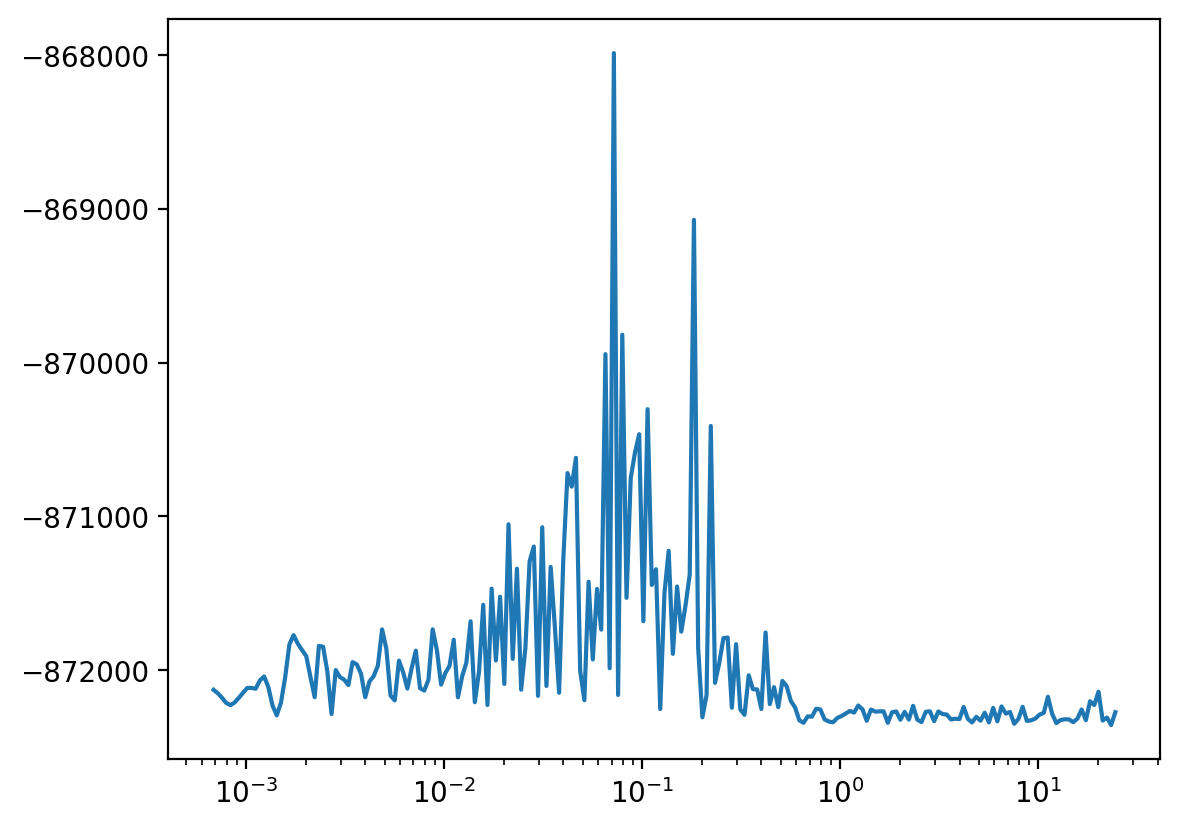

In [7]:
plt.plot(fgrid, logls)
plt.xscale('log')

100%|██████████| 215/215 [00:03<00:00, 58.13it/s]


(1, 100)

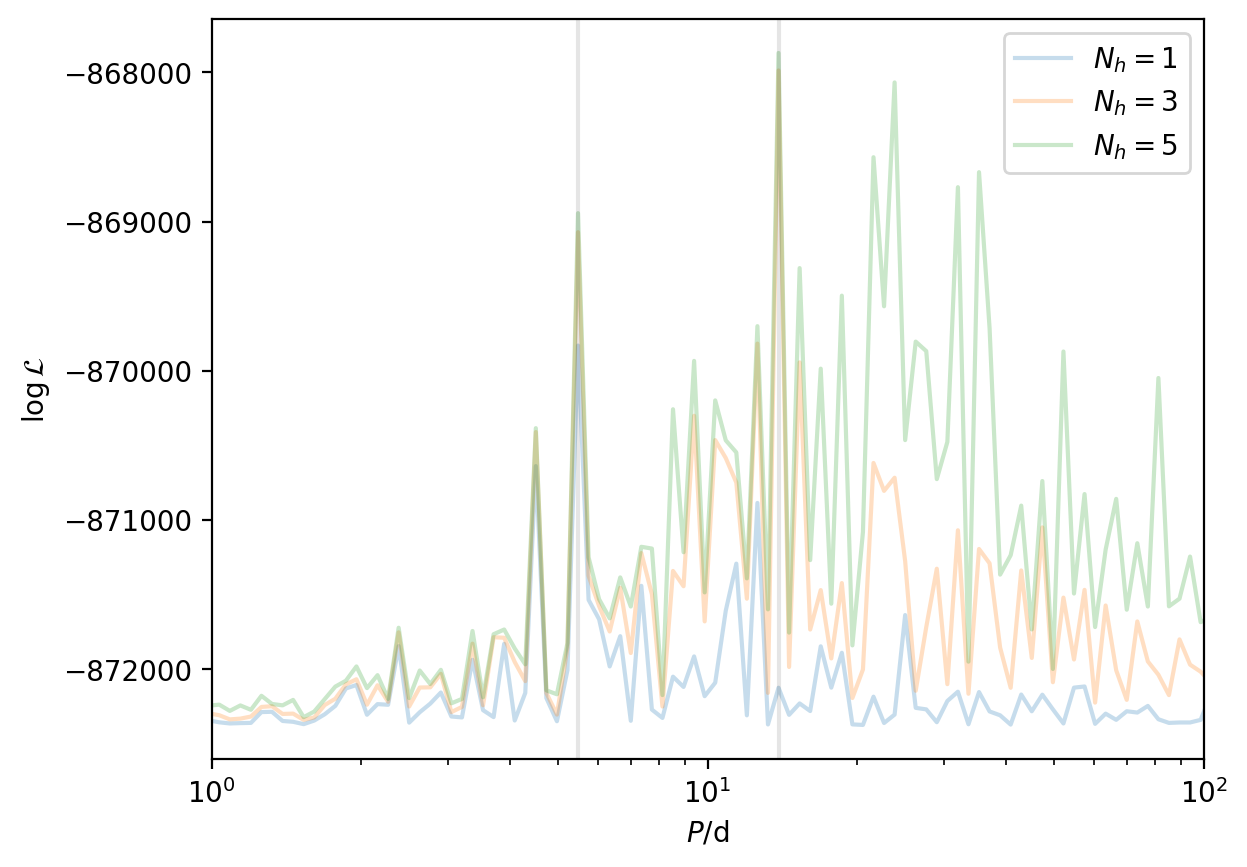

In [8]:
for nh in [1, 3, 5]:
    h = HarmonicLombScargle(times, fluxes, quarters, nh)
    fgrid = h.relative_frequency_grid(0.05)
    logls = h.logl_on_grid(fgrid)
    plt.plot(1/fgrid, logls, label=r'$N_h = {:d}$'.format(nh), alpha=0.25)
plt.xscale('log')
plt.xlabel(r'$P / \mathrm{d}$')
plt.ylabel(r'$\log \mathcal{L}$')
plt.legend()
plt.axvline(5.47, color='k', alpha=0.1)
plt.axvline(13.91, color='k', alpha=0.1)
plt.xlim(1, 100)

In [9]:
f_guess = fgrid[np.argmax(logls)]

fgrid_fine = hls.fine_frequency_grid(f_guess, 128)
logls_fine = hls.logl_on_grid(fgrid_fine)

100%|██████████| 128/128 [00:01<00:00, 72.12it/s]


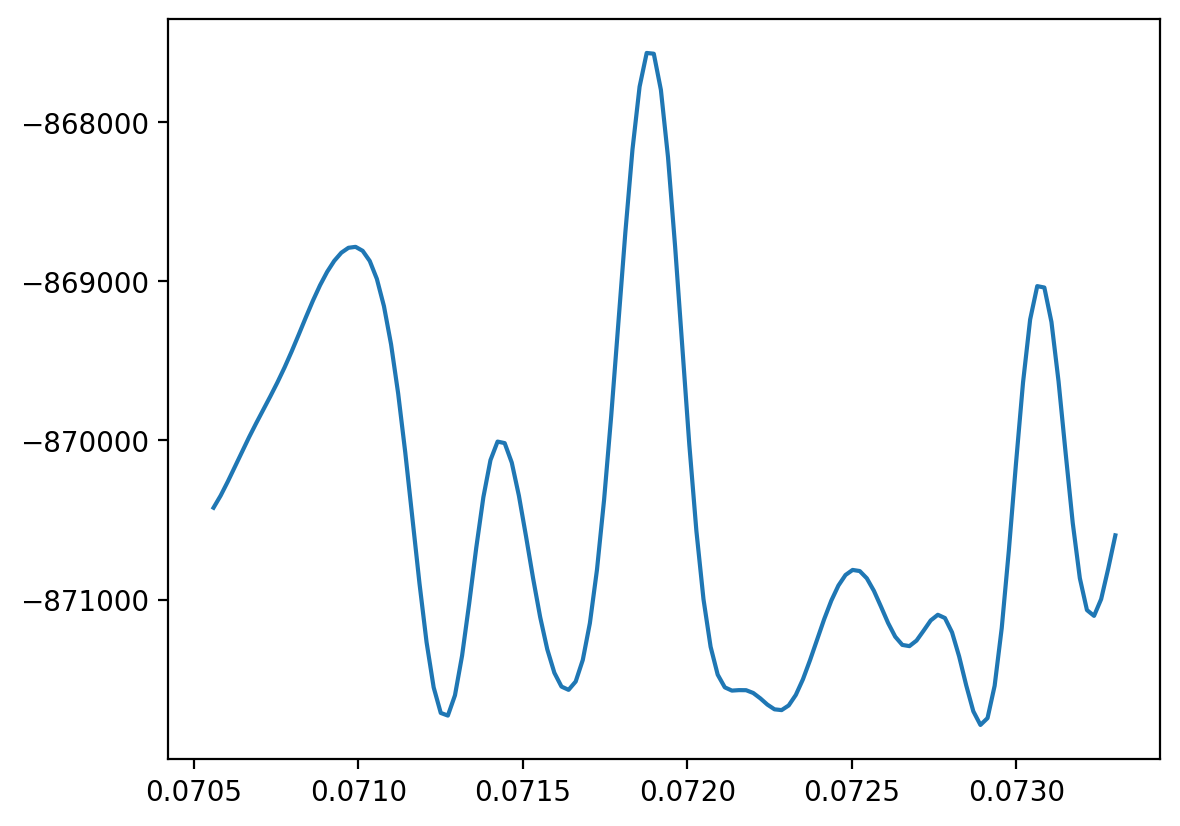

In [10]:
plt.plot(fgrid_fine, logls_fine)

In [11]:
f = hls.interpolated_best_frequency(fgrid_fine, logls_fine)
x_best = hls.best_fit_params(f)

print(f'f_best = {f}/day, or P = {1/f} days')

f_best = 0.07188693293022917/day, or P = 13.910733971229005 days


Text(0, 0.5, 'Residuals [e- / s]')

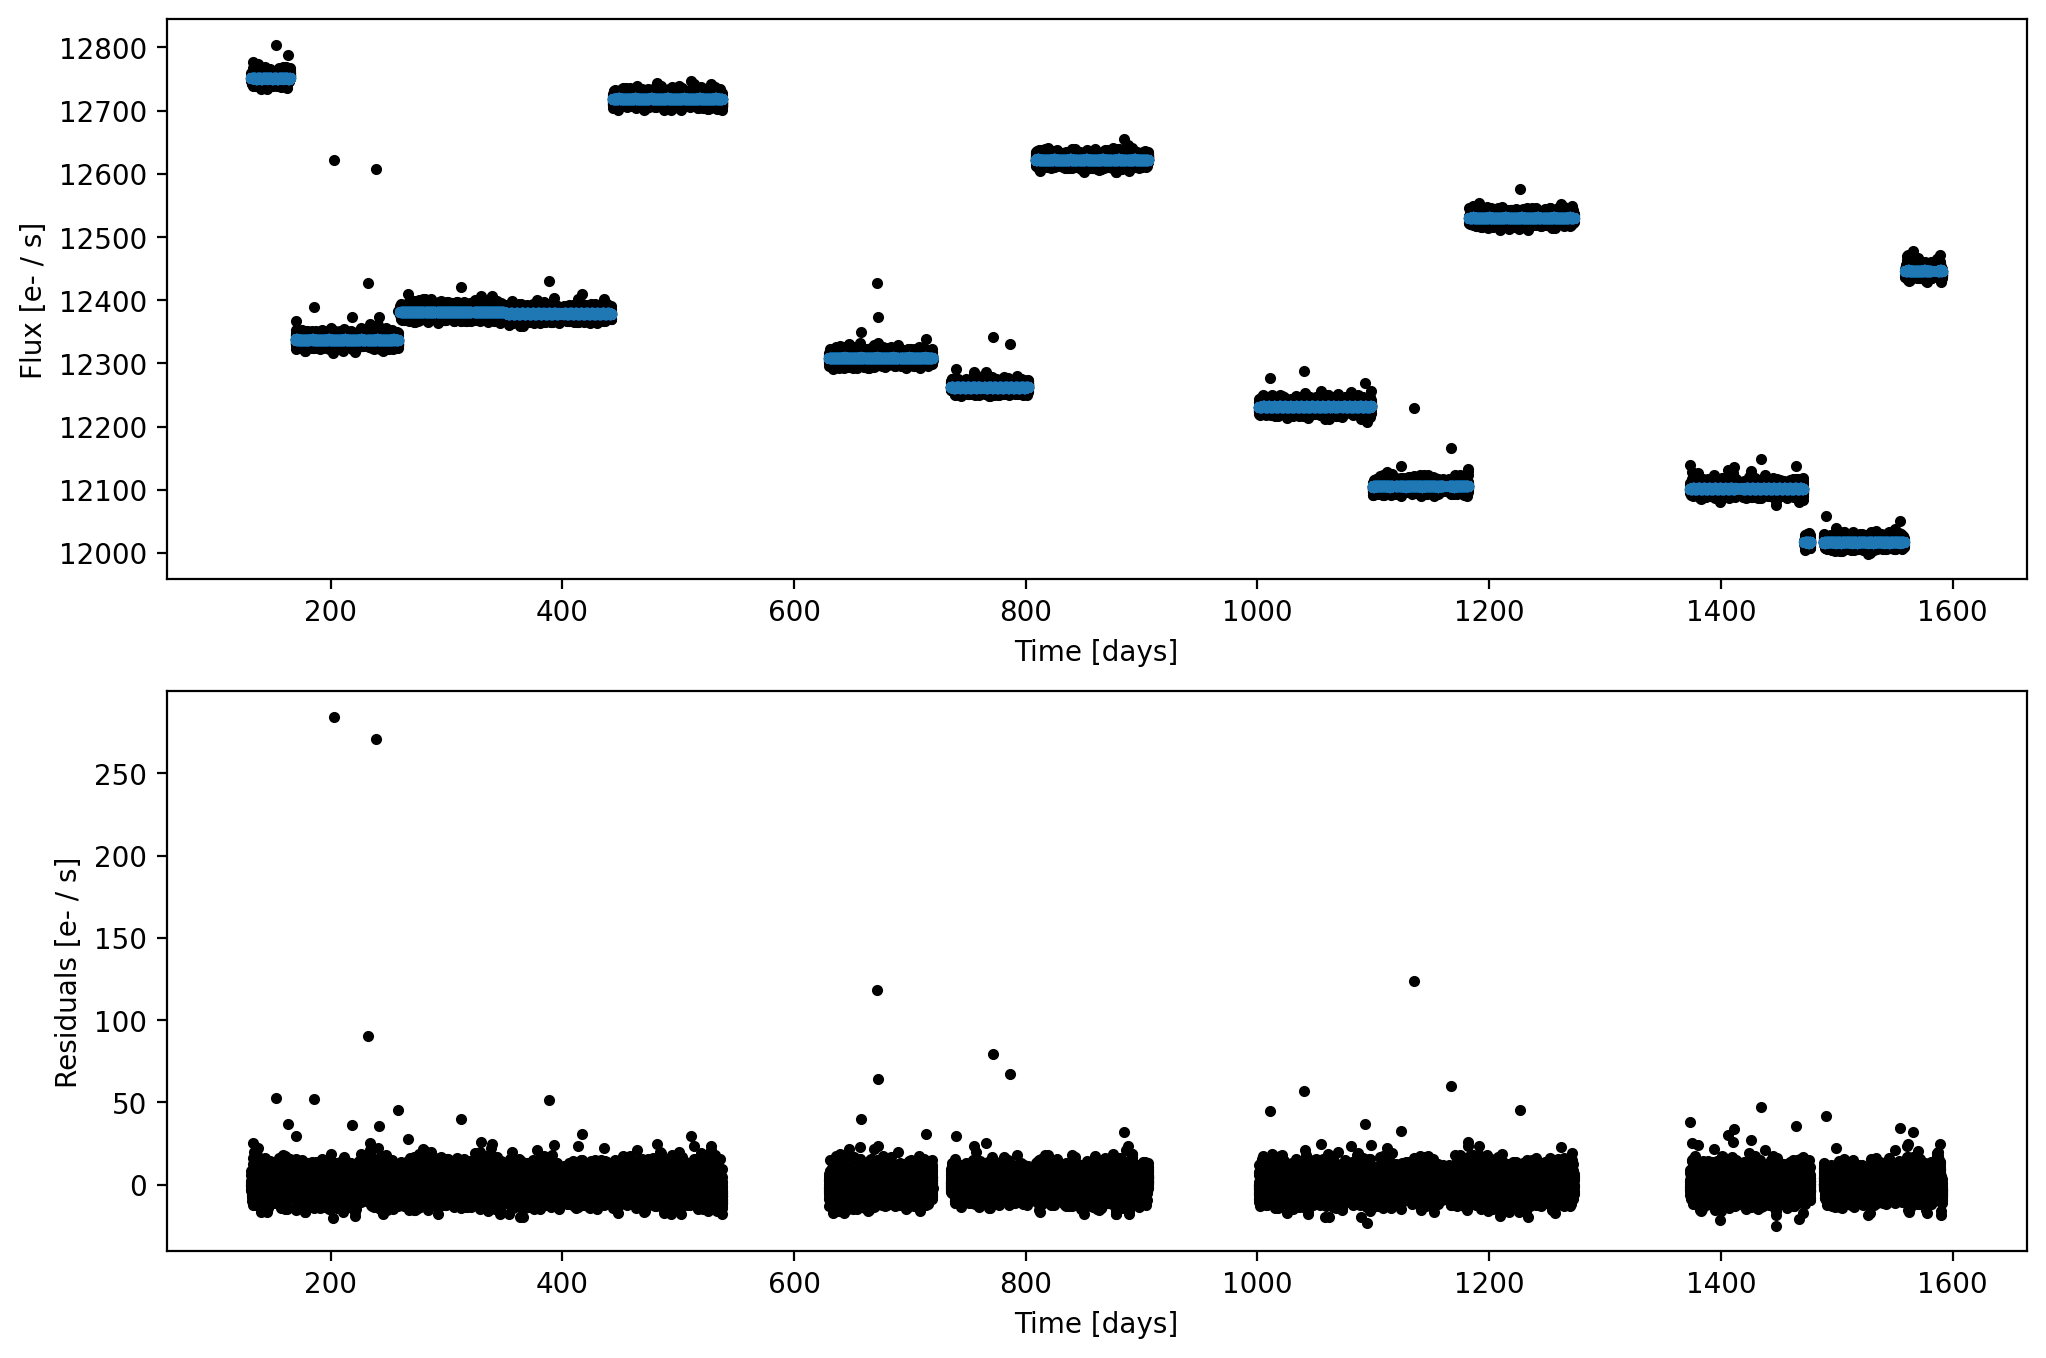

In [12]:
y = hls.predict_flux(f)

fig, subplots = plt.subplots(2, 1, figsize=(12, 8))

subplots[0].plot(times, fluxes, '.k')
subplots[0].plot(times, y, '.')
subplots[0].set_xlabel('Time [days]')
subplots[0].set_ylabel('Flux [e- / s]')

subplots[1].plot(times, fluxes - y, '.k')
subplots[1].set_xlabel('Time [days]')
subplots[1].set_ylabel('Residuals [e- / s]')

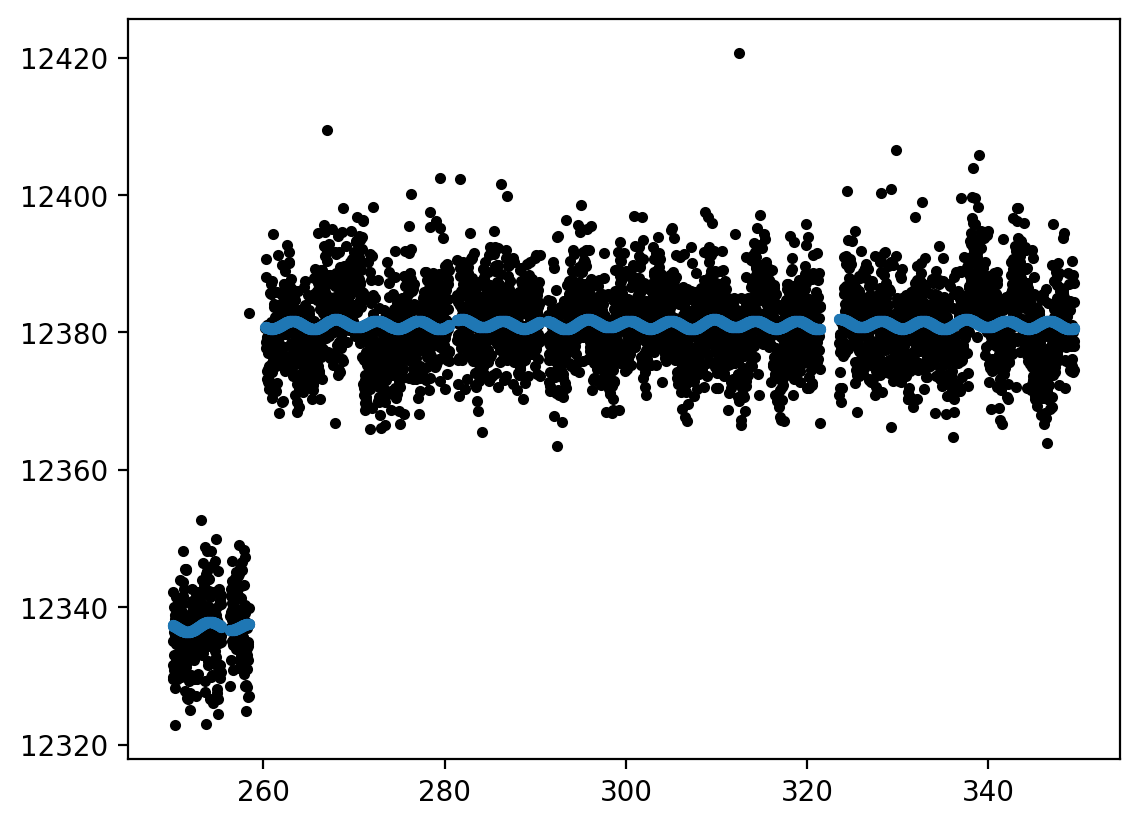

In [13]:
sel = np.abs(times - 300) < 50
plt.plot(times[sel], fluxes[sel], '.k')
plt.plot(times[sel], y[sel], '.')

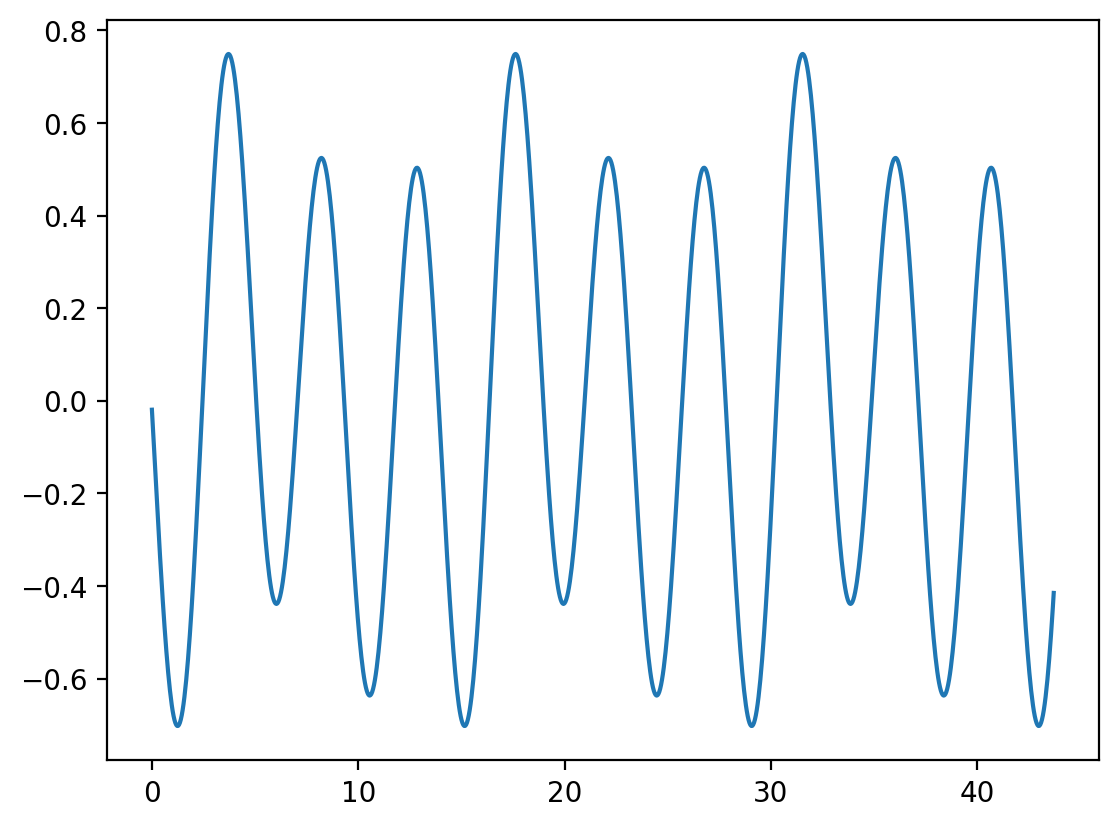

In [14]:
ts = np.linspace(0, np.pi*1/f, 1000)
plt.plot(ts, hls.periodic_lightcurve(ts, f, x_best))

In [234]:
def harmonic_SHO_model(t, y, yerr, yquarters, f0, nharmonics, mu_mu, mu_sigma, sho_sigma_prior, f0_frac_uncert=0.1):
    uquarters, quarter_indices = np.unique(yquarters, return_inverse=True)

    with pm.Model(coords={'harmonics': np.arange(nharmonics)+1, 'quarters': uquarters}) as model:
        nquarters = mu_mu.shape[0]

        mus_scaled = pm.Normal('mus_scaled', 0, 1, shape=(nquarters,), dims=['quarters'])
        mus = pm.Deterministic('mus', mus_scaled * mu_sigma + mu_mu, dims=['quarters'])

        y_centered = y - mus[quarter_indices]

        log_fs_scaled = pm.Normal('log_fs_scaled', 0, 1, shape=(nharmonics,), dims=['harmonics'])
        log_fs = pm.Deterministic('log_fs', log_fs_scaled*f0_frac_uncert + pt.log(f0) + pt.log(np.arange(nharmonics)+1), dims=['harmonics'])
        fs = pm.Deterministic('fs', pt.exp(log_fs + pt.log(np.arange(nharmonics) + 1)), dims=['harmonics'])

        log_Qs_scaled = pm.Normal('log_Qs_scaled', 0, 1, shape=(nharmonics,), dims=['harmonics'])
        log_Qs = pm.Deterministic('log_Qs', log_Qs_scaled * pt.log(10)/3 + pt.log(10), dims=['harmonics']) # LogNormal prior, peaks at Q = 10, 3-sigma width is a factor of 10
        Qs = pm.Deterministic('Qs', pt.exp(log_Qs), dims=['harmonics'])

        log_sigma_scaled = pm.Normal('log_sigma_scaled', 0, 1, shape=(nharmonics,), dims=['harmonics'])
        log_sigma = pm.Deterministic('log_sigma', pt.log(sho_sigma_prior) + pt.log(10)/2*log_sigma_scaled, dims=['harmonics'])
        sigmas = pm.Deterministic('sigmas', pt.exp(log_sigma), dims=['harmonics'])

        trms = [terms.SHOTerm(w0=2*np.pi*fs[i], Q=Qs[i], sigma=sigmas[i]) for i in range(nharmonics)]
        kernel = terms.TermSum(*trms)

        gp = GaussianProcess(kernel)
        gp.compute(t, yerr=yerr, quiet=True)
        pm.Potential('log_likelihood', gp.log_likelihood(y_centered))

        return model

In [235]:
n_in_quarters = np.bincount(quarter_indices)
quarter_means = np.bincount(quarter_indices, weights=fluxes) / n_in_quarters
quarter_vars = np.bincount(quarter_indices, weights=(fluxes - quarter_means[quarter_indices])**2) / n_in_quarters
quarter_stds = np.sqrt(quarter_vars)

total_var = np.sum(quarter_vars * n_in_quarters) / np.sum(n_in_quarters)
total_std = np.sqrt(total_var)

In [260]:
nharmonics = 2
thin_data = 30
model = harmonic_SHO_model(times[::thin_data], fluxes[::thin_data], flux_errs[::thin_data], quarters[::thin_data], 3*f, nharmonics, quarter_means, quarter_stds, total_std)

In [261]:
trace = pm.sample(tune=1000, draws=1000, cores=2, chains=2, model=model, progressbar=True, jitter_max_retries=100, init='adapt_full')

Initializing NUTS using adapt_full...
/Users/wfarr/miniconda3/envs/harmonic-lomb-scargle/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:760: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mus_scaled, log_fs_scaled, log_Qs_scaled, log_sigma_scaled]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'mus_scaled'}>,
        <Axes: title={'center': 'mus_scaled'}>],
       [<Axes: title={'center': 'log_fs_scaled'}>,
        <Axes: title={'center': 'log_fs_scaled'}>],
       [<Axes: title={'center': 'log_Qs_scaled'}>,
        <Axes: title={'center': 'log_Qs_scaled'}>],
       [<Axes: title={'center': 'log_sigma_scaled'}>,
        <Axes: title={'center': 'log_sigma_scaled'}>],
       [<Axes: title={'center': 'mus'}>, <Axes: title={'center': 'mus'}>],
       [<Axes: title={'center': 'log_fs'}>,
        <Axes: title={'center': 'log_fs'}>],
       [<Axes: title={'center': 'fs'}>, <Axes: title={'center': 'fs'}>],
       [<Axes: title={'center': 'log_Qs'}>,
        <Axes: title={'center': 'log_Qs'}>],
       [<Axes: title={'center': 'Qs'}>, <Axes: title={'center': 'Qs'}>],
       [<Axes: title={'center': 'log_sigma'}>,
        <Axes: title={'center': 'log_sigma'}>],
       [<Axes: title={'center': 'sigmas'}>,
        <Axes: title={'center': 'sigmas'}>]], dtyp

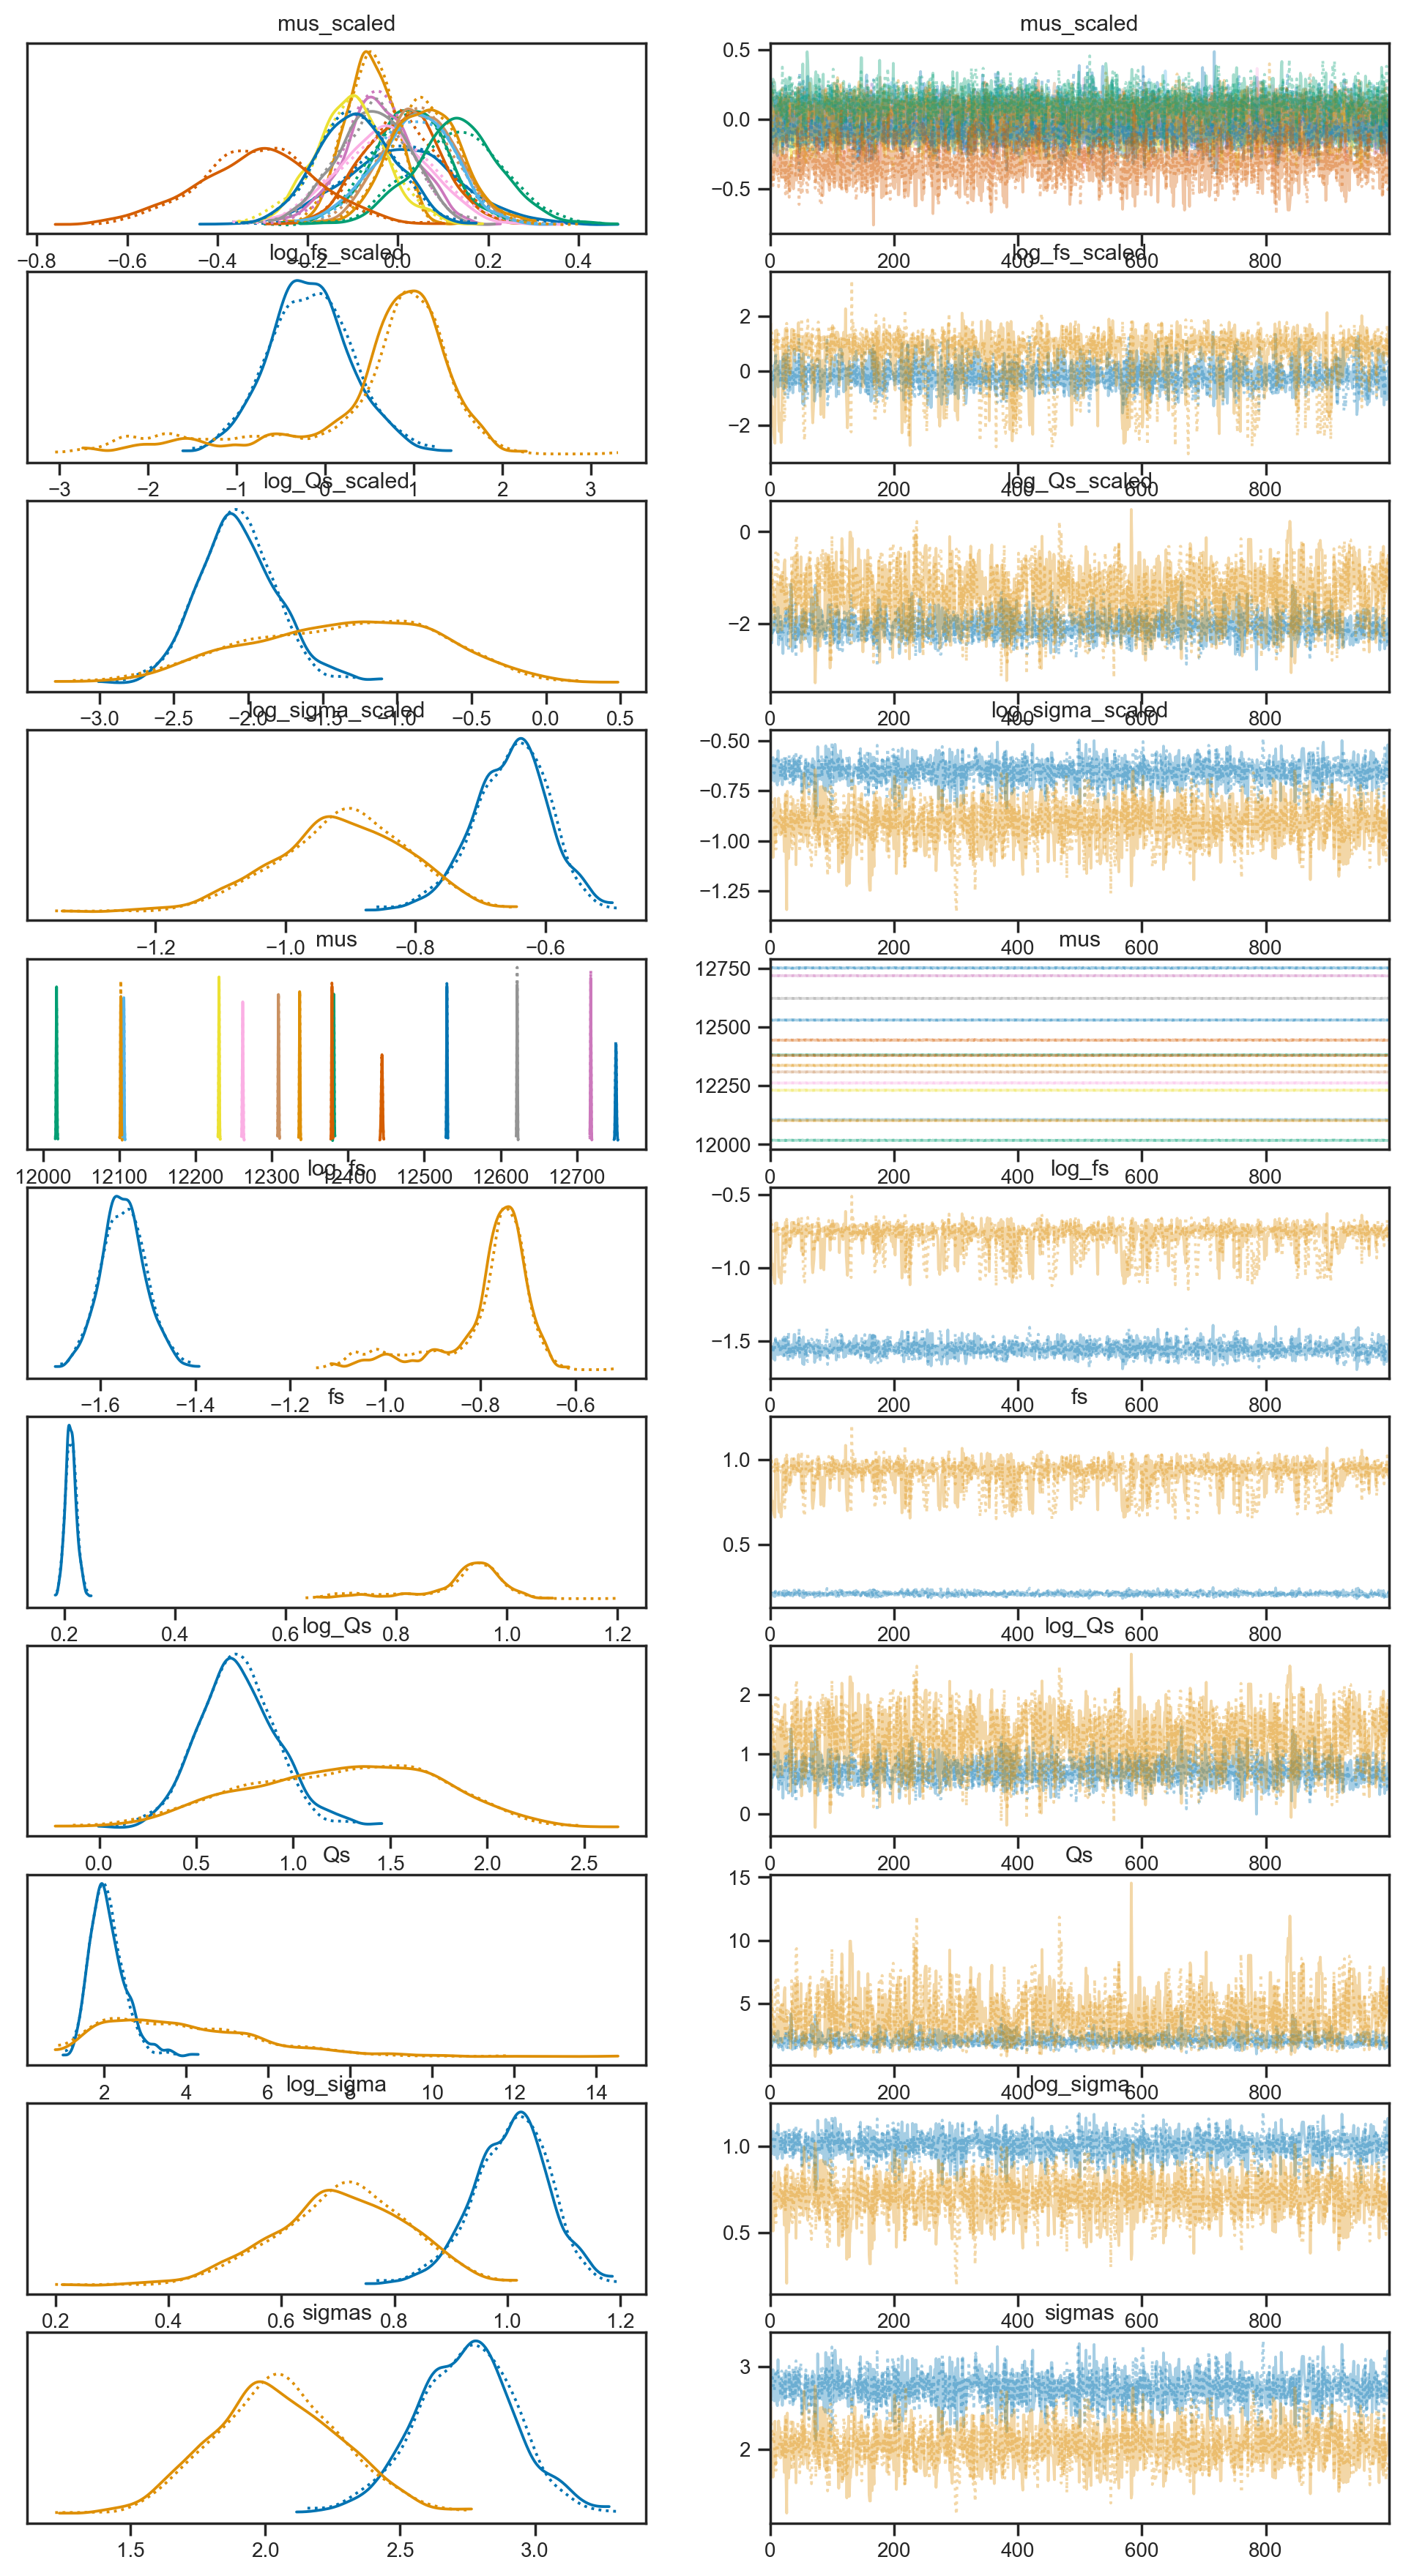

In [262]:
az.plot_trace(trace)

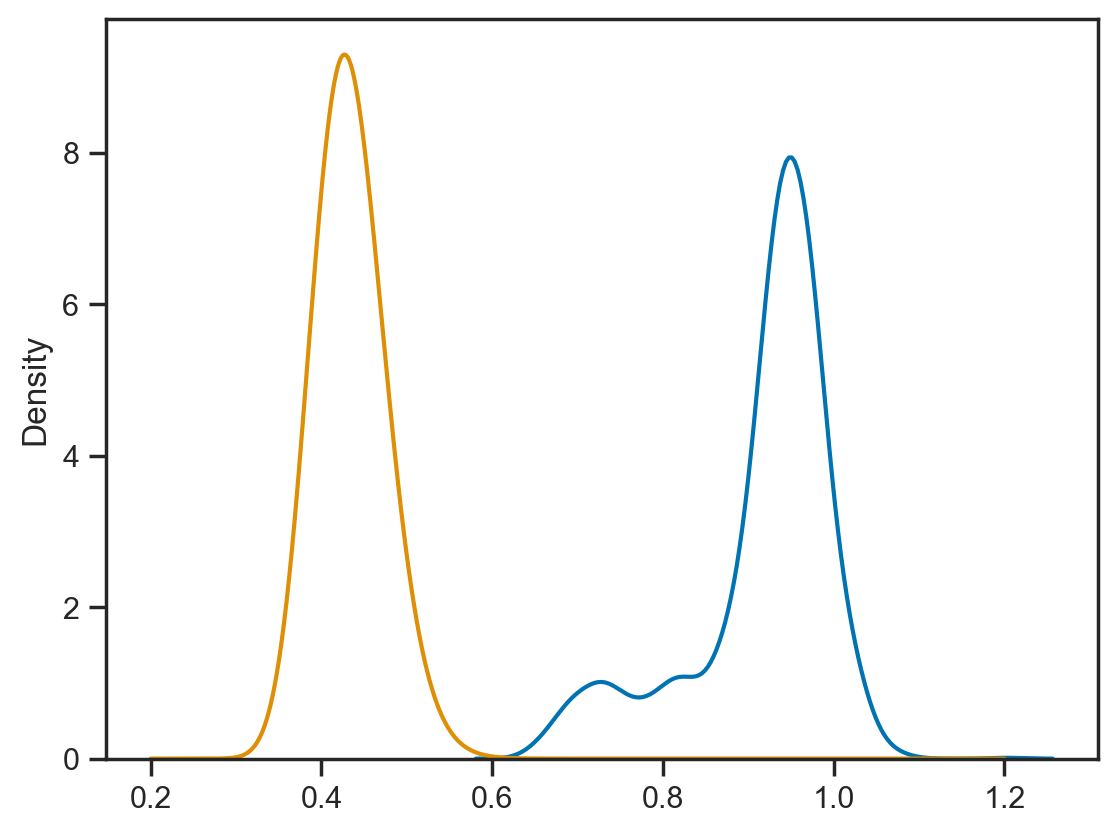

In [266]:
sns.kdeplot(trace.posterior.fs.sel(harmonics=2).values.flatten())
x = np.linspace(0.2, 1.2, 1000)
plt.plot(x, ss.lognorm(0.1, scale=6*f).pdf(x))

<Axes: ylabel='Density'>

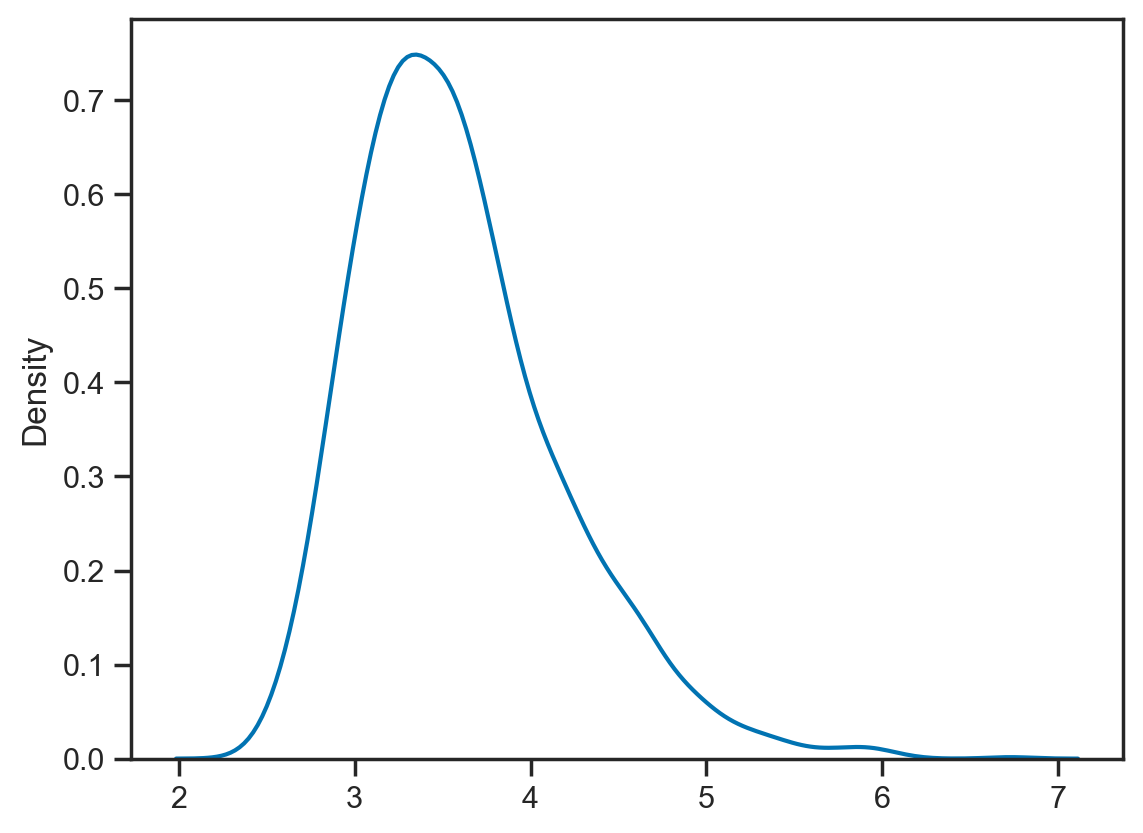

In [249]:
sns.kdeplot((trace.posterior.fs.sel(harmonics=2)/trace.posterior.fs.sel(harmonics=1)).values.flatten())